## Analysis of Drug sensitivity deconvolution results 

Here we explore the results obtained with `CLIFF` method in the notebook `01_cliff_invitro_run.ipynb`.

In [133]:
library(glmnet) ; library(ggplot2) ; library(reshape2)
library(CoreGx) ; library(PharmacoGx) ; library(climb)
library(sigmoid); library(ComplexHeatmap) ; library(circlize)
library(abind)  ; library(ggpmisc)

In [134]:
# We load CLIMB and CLIFF library
library(climb) ; library(cliff)

In [279]:
# update CLIFF
detach("package:cliff", unload=TRUE)
devtools::install_github('alexdray86/cliff-R', force=T)
library(cliff)

── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/z6/0fzn0d4s1v74_s44tjrc9mg00000gp/T/RtmpLOh6XA/remotes22a123a1040a/alexdray86-cliff-R-c3fe59b/DESCRIPTION’
─  preparing ‘cliff’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘cliff_0.0.1.2.tar.gz’
   



Attaching package: ‘cliff’


The following objects are masked _by_ ‘.GlobalEnv’:

    mse, rmse




In [10]:
# Define constant variables
# log_dose to compute AUC 
log_dose = c(-9.205031395,-8.699881554,-8.13012790,-7.70415926,-7.209309101,-6.70415926,-6.125806332,-5.699837685,-5.204987526,-4.699837685)
doses = 10^log_dose * 1e6

# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x))) }
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }

# Function to load all deconvoluted proportions
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,as.character(celltype_names)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,as.character(celltype_names)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,as.character(celltype_names)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,as.character(celltype_names)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,as.character(celltype_names)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='X')[,as.character(celltype_names)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_prop) ; true_prop_rows = rownames(true_prop)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}      

                                                                                                      reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,as.character(celltype_names)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,as.character(celltype_names)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,as.character(celltype_names)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,as.character(celltype_names)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,as.character(celltype_names)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,as.character(celltype_names)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_p) ; true_prop_rows = rownames(true_p)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}   

Here we generate a function to compute the area under the curve based on multiple drug doses using a function from `PharmacoGx` package. The idea is to summarize drug sensitivity integrating all data points from each drug dose, to get a single dot for each combination of drug, and timepoints.

In [11]:
computeAUC_ = function(viability){
    # ComputeAUC returns (1-Viability), it is thus a score of drug sensitivity
    computeAUC(doses, viability, viability_as_pct=FALSE, area.type = 'Fitted', trunc = FALSE, verbose = FALSE)
}

## Load Data

In [12]:
# load proportions from diverse deconvolution methods
all_props = load_all_props('data/invitro_climb/tables/', include_cibersortx=T)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [13]:
df_raw_drug_data = read.csv("data/invitro_climb/invitro_drug_resp.csv", row.names = 'X')
head(df_raw_drug_data)

,sample_name,dose,timepoint,drug,viability
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,SUDHL4_n1,d1,48h,5Aza2d,1.641807
2,SUDHL4_n1,d2,48h,5Aza2d,1.621849
3,SUDHL4_n1,d3,48h,5Aza2d,1.583508
4,SUDHL4_n1,d4,48h,5Aza2d,1.528887
5,SUDHL4_n1,d5,48h,5Aza2d,1.381828
6,SUDHL4_n1,d6,48h,5Aza2d,1.344538


In [14]:
df_raw_drug_data = df_raw_drug_data[df_raw_drug_data$drug != 'Oxaliplatin',]

In [15]:
df_raw_drug_data$sample = gsub('_.*','',df_raw_drug_data$sample_name)

In [16]:
# we average over duplicates
df_raw_drug_data_av = aggregate(num(df_raw_drug_data$viability), list(df_raw_drug_data$sample, df_raw_drug_data$timepoint, df_raw_drug_data$drug, df_raw_drug_data$dose), mean)
colnames(df_raw_drug_data_av) = c('sample', 'timepoint', 'drug', 'dose', 'viability')

In [17]:
df_raw_drug_data_av$uniq_id = paste0(df_raw_drug_data_av$drug, '_', df_raw_drug_data_av$timepoint, '-', df_raw_drug_data_av$dose)
head(df_raw_drug_data_av)

,sample,timepoint,drug,dose,viability,uniq_id
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,BULK1,48h,5Aza2d,d1,1.128118,5Aza2d_48h-d1
2,BULK2,48h,5Aza2d,d1,1.068903,5Aza2d_48h-d1
3,BULK3,48h,5Aza2d,d1,1.070443,5Aza2d_48h-d1
4,BULK4,48h,5Aza2d,d1,1.003933,5Aza2d_48h-d1
5,BULK5,48h,5Aza2d,d1,1.069722,5Aza2d_48h-d1
6,BULK6,48h,5Aza2d,d1,1.105953,5Aza2d_48h-d1


In [18]:
bulk_raw_data = df_raw_drug_data_av[grepl('BULK',df_raw_drug_data_av$sample),]

In [19]:
bulk_raw_data = bulk_raw_data[,c('sample','uniq_id','viability')]
colnames(bulk_raw_data) = c('sample', 'drug', 'viability')
head(bulk_raw_data)

,sample,drug,viability
,<chr>,<chr>,<dbl>
1,BULK1,5Aza2d_48h-d1,1.128118
2,BULK2,5Aza2d_48h-d1,1.068903
3,BULK3,5Aza2d_48h-d1,1.070443
4,BULK4,5Aza2d_48h-d1,1.003933
5,BULK5,5Aza2d_48h-d1,1.069722
6,BULK6,5Aza2d_48h-d1,1.105953


In [20]:
agg_cell_line = aggregate(df_raw_drug_data$viability, list(df_raw_drug_data$sample_name, df_raw_drug_data$timepoint, df_raw_drug_data$drug), computeAUC_)
# renaming column and generate sample name from replicate names
colnames(agg_cell_line) <- c('replicate', 'timepoint', 'drug', 'auc')
agg_cell_line$sample = gsub('_.*','',agg_cell_line$replicate)
# we average over duplicates
auc_cell_line = aggregate(num(agg_cell_line$auc), list(agg_cell_line$sample, agg_cell_line$timepoint, agg_cell_line$drug), mean)
# renaming
colnames(auc_cell_line) <- c('sample', 'timepoint', 'drug', 'auc')
auc_cell_line$uniq_id = paste0(auc_cell_line$drug, '_', auc_cell_line$timepoint)
head(auc_cell_line)

,sample,timepoint,drug,auc,uniq_id
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,BULK1,48h,5Aza2d,0.09961642,5Aza2d_48h
2,BULK2,48h,5Aza2d,0.12332685,5Aza2d_48h
3,BULK3,48h,5Aza2d,0.12984720,5Aza2d_48h
4,BULK4,48h,5Aza2d,0.13563668,5Aza2d_48h
5,BULK5,48h,5Aza2d,0.12739408,5Aza2d_48h
6,BULK6,48h,5Aza2d,0.11713985,5Aza2d_48h


In [21]:
bulk_auc_data = auc_cell_line[grepl('BULK',auc_cell_line$sample),]
true_auc_cell_line = auc_cell_line[!grepl('BULK',auc_cell_line$sample),]

In [22]:
bulk_auc_data = bulk_auc_data[,c('sample','uniq_id','auc')]
colnames(bulk_auc_data) = c('sample', 'drug', 'auc')
head(bulk_auc_data)

,sample,drug,auc
,<chr>,<chr>,<dbl>
1,BULK1,5Aza2d_48h,0.09961642
2,BULK2,5Aza2d_48h,0.12332685
3,BULK3,5Aza2d_48h,0.12984720
4,BULK4,5Aza2d_48h,0.13563668
5,BULK5,5Aza2d_48h,0.12739408
6,BULK6,5Aza2d_48h,0.11713985


## Load scRNA-seq and bulk RNA-seq and perform CLIMB deconvolution in expression mode

In [23]:
# Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
sc.es = readRDS("data/invitro_climb/invitro_sc_es.RDS")
bulk.es = readRDS("data/invitro_climb/invitro_bulk_es.RDS")
true_prop = as.matrix(pData(bulk.es))
sc.es$cellType = factor(sc.es$cellType, level=unique(sc.es$cellType))

In [233]:
# Launch CLIMB in expression mode - takes around 15 minutes
climb_res = climb(sc.es, bulk.es, norm_coefs = T, dwls_weights = T,  mode='expression', cancer_pattern = '*')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution

High-Resolution expression prediction: 1000 genes processed...

High-Resolution expression prediction: 2000 genes processed...

High-Resolution expression prediction: 3000 genes processed...

High-Resolution expression prediction: 4000 genes processed...

High-Resolution expression prediction: 5000 genes processed...

High-Resolution expression prediction: 6000 genes processed...



In [228]:
saveRDS(climb_res, 'data/invitro_climb/climb_out_expression_nFwT.RDS')

In [238]:
climb_res = readRDS('data/invitro_climb/climb_out_expression.RDS')

## Run CLIFF on all drugs / timepoints 

We run CLIFF in default mode for all drugs / timepoints, with >10 genes in the selection (c.f. optimization of gene selection below).

In [293]:
uniq_conditions = unique(bulk_auc_data$drug)
average_pidk = matrix(nrow=length(uniq_conditions), ncol=4)
true_pidk = matrix(nrow=length(uniq_conditions), ncol=4)
average_pidk_highres = matrix(nrow=length(uniq_conditions), ncol=4)
all_cors_overall = list() ; all_cors_highres = list() ; 
all_rmse_overall = list() ; all_rmse_highres = list() ; 
for(i in 1:length(uniq_conditions)){
    this_condition = uniq_conditions[i]
    message(this_condition)
    bulk_auc_data.sub = bulk_auc_data[bulk_auc_data$drug == this_condition,]
    
    # Feature Selection - cliff_gene_selection function imported with CLIFF package
    bulk_mat = t(exprs(bulk.es))
    drug_data = bulk_auc_data.sub$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=10)
    
    # Subset CLIMB output with selected genes
    climb_res.filt = climb_res
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
    
    # Launch CLIFF - overall mode
    cliff_highres = cliff(climb_res.filt, bulk_auc_data.sub, max.em.steps = 100, mode='overall')[[1]]  

    average_pidk[i,] = num(colMeans(cliff_highres))
    true_pidk[i,] = num(true_auc_cell_line[grepl(this_condition, true_auc_cell_line$uniq_id),]$auc)
    all_cors_overall[[i]] = cor(average_pidk[i,], true_pidk[i,])
    all_rmse_overall[[i]] = rmse(average_pidk[i,], true_pidk[i,])
    message(paste0('PCC = ', cor(average_pidk[i,], true_pidk[i,])))

    # Feature Selection - cliff_gene_selection function imported with CLIFF package
    bulk_mat = t(exprs(bulk.es))
    drug_data = bulk_auc_data.sub$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=200)
    # Subset CLIMB output with selected genes
    climb_res.filt = climb_res
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
    
    # Launch CLIFF - high-resolution mode
    cliff_highres = cliff(climb_res.filt, bulk_auc_data.sub, max.em.steps = 100, mode='highres')[[1]]  

    average_pidk_highres[i,] = num(colMeans(cliff_highres))
    all_cors_highres[[i]] = cor(average_pidk_highres[i,], true_pidk[i,])
    all_rmse_highres[[i]] = rmse(average_pidk_highres[i,], true_pidk[i,])
    message(paste0('PCC = ', cor(average_pidk_highres[i,], true_pidk[i,])))
}

5Aza2d_48h

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

PCC = 0.277393802995777

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

PCC = 0.0162508550103326

5Aza2d_72h

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 14

PCC = -0.50867364620101

Prepare CLIFF input from CLIMB output, mutation

PCC = 0.791210939604099

Mitomycin_72h

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

PCC = 0.870927406835322

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

PCC = 0.129834013279226

Mitomycin_96h

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

PCC = -0.0469773918422627

Prepare CLIFF in

In [294]:
# Correlation "overall" for all data points
cor(flatten(average_pidk), flatten(true_pidk))
cor(flatten(average_pidk_highres), flatten(true_pidk))

[1] 0.7964146

[1] 0.5893372

In [295]:
# Correlation per condition (4 predicted cell line sensitivity versus 4 true, for all drugs x timepoint)
cliff_cors_overall = num(all_cors_overall)
cliff_cors_highres = num(all_cors_highres)
median(cliff_cors_overall)
median(cliff_cors_highres)

[1] 0.8159327

[1] 0.7231324

In [296]:
# RMSE per condition (4 predicted cell line sensitivity versus 4 true, for all drugs x timepoint)
cliff_rmse_overall = num(all_rmse_overall)
cliff_rmse_highres = num(all_rmse_highres)
median(cliff_rmse_overall)
median(cliff_rmse_highres)

[1] 0.122392

[1] 0.1335915

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

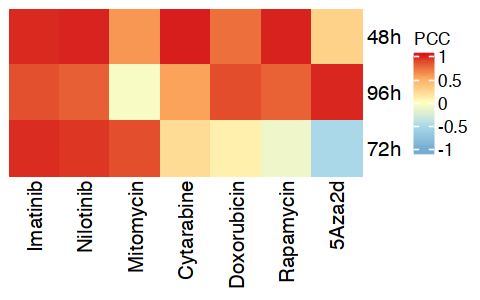

In [297]:
## CLIFF-overall
rownames(average_pidk) = uniq_conditions ; colnames(average_pidk) = colnames(climb_res$props)
rownames(true_pidk) = uniq_conditions ; colnames(true_pidk) = colnames(climb_res$props)
drug_sens_m = cbind(melt(average_pidk), melt(true_pidk))[,c(1,2,3,6)]
colnames(drug_sens_m) = c('id', 'celltype', 'pred', 'true')
drug_sens_m$timepoint = gsub('.*_','',drug_sens_m$id)
drug_sens_m$drug = gsub('_.*','',drug_sens_m$id)

df_cors = data.frame(pcc=num(all_cors_overall), condition=uniq_conditions)
df_cors$timepoint = gsub('.*_','',df_cors$condition)
df_cors$drug = gsub('_.*','',df_cors$condition)
mat_cors = dcast(df_cors, timepoint ~ drug, value.var = 'pcc')
rownames(mat_cors) = mat_cors[,1]
mat_cors = mat_cors[,-1]

col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1,-0.5,0,0.5,1), col_panel)
h <- Heatmap(mat_cors, col=col_fun, show_row_dend = F, show_column_dend = F, name='PCC')
options(repr.plot.width = 4, repr.plot.height = 2.5)
pdf('results/fig5/invitro_cliff_overall_drug_vs_timpoint_PCC.pdf', width=4, height=2.5) ; h ; dev.off()
h

pdf 
  2

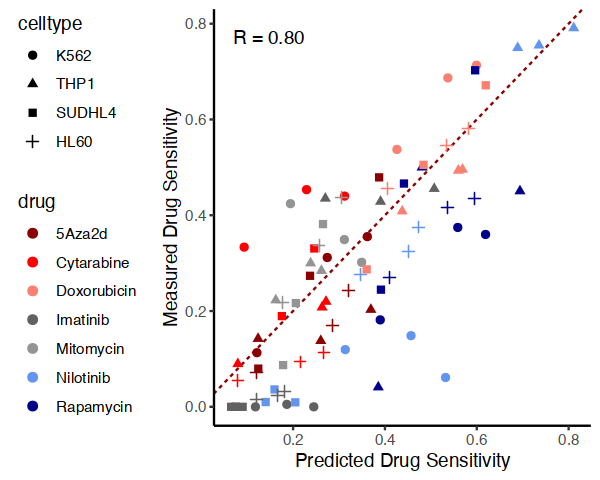

In [299]:
options(repr.plot.width = 5, repr.plot.height = 4)
# We then plot the result :
g <- ggplot(data = drug_sens_m, aes(x=pred, y=true)) +
    stat_correlation(data = drug_sens_m, aes(x=num(pred), y=num(true)))+
    geom_abline(intercept =0 , slope = 1, color='darkred', linetype='dashed') +
    geom_point(aes(color=drug, shape=celltype), size=2)+ theme_classic() + theme(legend.position="left") +
    scale_color_manual(values=c('darkred', 'red', 'salmon', 'grey38', 'grey58', 'cornflowerblue', 'darkblue')) +
    xlab('Predicted Drug Sensitivity') + ylab('Measured Drug Sensitivity') 
pdf('results/fig5/invitro_cliff_overall_pred_vs_true_drugsensitivity.pdf', width=5, height=4) ; g ; dev.off()
g

No id variables; using all as measure variables



pdf 
  2

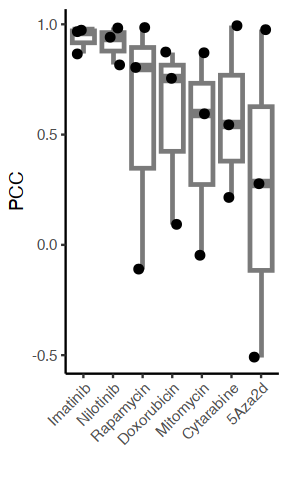

In [302]:
mat_cors_drugs = melt(mat_cors)
colnames(mat_cors_drugs) = c('drug', 'PCC')
agg_ = aggregate(mat_cors_drugs$PCC, list(mat_cors_drugs$drug), median)
levels_ = as.character(agg_$`Group.1`[order(-1*agg_$x)])
mat_cors_drugs$drug = factor(mat_cors_drugs$drug, levels = levels_)
options(repr.plot.width = 2.4, repr.plot.height = 4)
g <- ggplot(mat_cors_drugs, aes(x=drug, y=num(PCC))) + geom_boxplot(size=1, color='grey48') +
    geom_jitter(size=2, color='black',width=0.25, height=0) +theme_classic() +
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('') + ylab('PCC')
pdf('results/fig5/boxplot_drug_comparison.pdf', width=2.4, height=4) ; g ; dev.off()
g

In [303]:
all_celltype = unique(drug_sens_m$celltype)
pcc_per_celltype = list()
for(d in 1:length(all_celltype)){
    drug_sens_m.d = drug_sens_m[drug_sens_m$celltype == all_celltype[d],]
    all_timepoints = unique(drug_sens_m.d$timepoint) ; pcc_per_timepoint = list()
    for(t in 1:length(all_timepoints)){
        drug_sens_m.d.t = drug_sens_m.d[drug_sens_m.d$timepoint == all_timepoints[t],]
        pcc_per_timepoint[[t]] = cor(num(drug_sens_m.d.t$pred), num(drug_sens_m.d.t$true))
    }
    pcc_per_celltype[[d]] = num(pcc_per_timepoint)
}

pdf 
  2

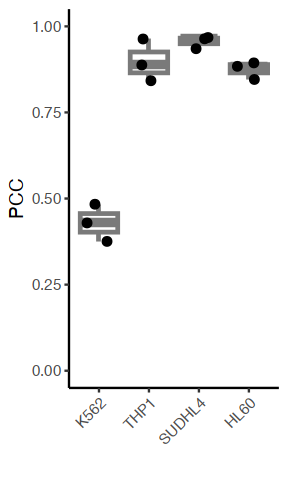

In [304]:
df_per_celltype = do.call(rbind, pcc_per_celltype)
rownames(df_per_celltype) = all_celltype ; colnames(df_per_celltype) = all_timepoints
df_per_celltype_melt = melt(df_per_celltype)
colnames(df_per_celltype_melt) = c('celltype', 'timepoint', 'PCC')
options(repr.plot.width = 2.4, repr.plot.height = 4)
g <- ggplot(df_per_celltype_melt, aes(x=celltype, y=num(PCC))) + geom_boxplot(size=1, color='grey48') +
    geom_jitter(size=2, color='black',width=0.25, height=0) +theme_classic() +ylim(c(0,1))+ 
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('') + ylab('PCC')
pdf('results/fig5/boxplot_celltype_comparison.pdf', width=2.4, height=4) ; g ; dev.off()
g

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

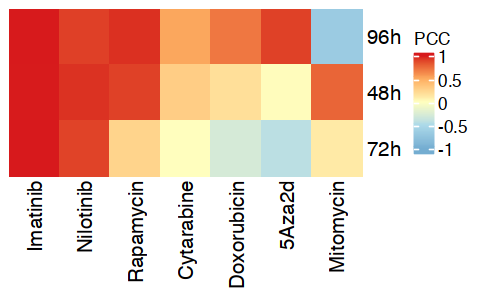

In [305]:
## CLIFF-highres
rownames(average_pidk_highres) = uniq_conditions ; colnames(average_pidk_highres) = colnames(climb_res$props)
rownames(true_pidk) = uniq_conditions ; colnames(true_pidk) = colnames(climb_res$props)
drug_sens_m = cbind(melt(average_pidk_highres), melt(true_pidk))[,c(1,2,3,6)]
colnames(drug_sens_m) = c('id', 'celltype', 'pred', 'true')
drug_sens_m$timepoint = gsub('.*_','',drug_sens_m$id)
drug_sens_m$drug = gsub('_.*','',drug_sens_m$id)

df_cors = data.frame(pcc=num(all_cors_highres), condition=uniq_conditions)
df_cors$timepoint = gsub('.*_','',df_cors$condition)
df_cors$drug = gsub('_.*','',df_cors$condition)
mat_cors = dcast(df_cors, timepoint ~ drug, value.var = 'pcc')
rownames(mat_cors) = mat_cors[,1]
mat_cors = mat_cors[,-1]

col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1,-0.5,0,0.5,1), col_panel)
h <- Heatmap(mat_cors, col=col_fun, show_row_dend = F, show_column_dend = F, name='PCC')
options(repr.plot.width = 4, repr.plot.height = 2.5)
pdf('results/fig5/invitro_cliff_highres_drug_vs_timpoint_PCC.pdf', width=4, height=2.5) ; h ; dev.off()
h

In [306]:
mean(num(all_cors_highres))

[1] 0.4845624

pdf 
  2

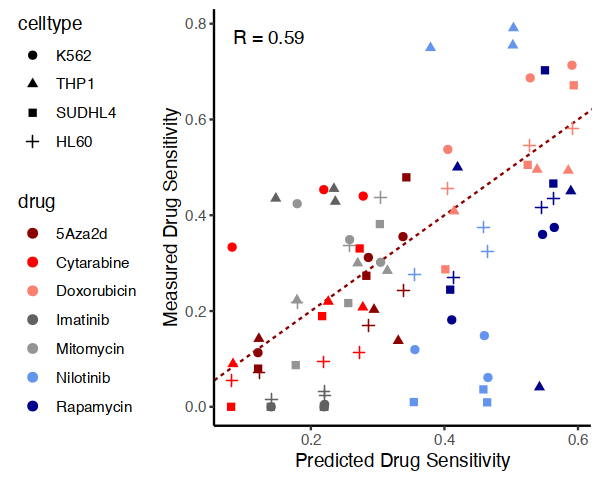

In [307]:
options(repr.plot.width = 5, repr.plot.height = 4)
# We then plot the result :
g <- ggplot(data = drug_sens_m, aes(x=pred, y=true)) +
    stat_correlation(data = drug_sens_m, aes(x=num(pred), y=num(true)))+
    geom_abline(intercept =0 , slope = 1, color='darkred', linetype='dashed') +
    geom_point(aes(color=drug, shape=celltype), size=2)+ theme_classic() + theme(legend.position="left") +
    scale_color_manual(values=c('darkred', 'red', 'salmon', 'grey38', 'grey58', 'cornflowerblue', 'darkblue')) +
    xlab('Predicted Drug Sensitivity') + ylab('Measured Drug Sensitivity') 
pdf('results/fig5/invitro_cliff_highres_pred_vs_true_drugsensitivity.pdf', width=5, height=4) ; g ; dev.off()
g

### Karakhalsar et al. approach: Linear Regression with MuSiC proportions

In [256]:
uniq_conditions = unique(bulk_auc_data$drug)
average_pidk_linreg = matrix(nrow=length(uniq_conditions), ncol=4)
true_pidk_linreg = matrix(nrow=length(uniq_conditions), ncol=4)
all_cors_linreg = list() ; all_rmse_linreg = list()
for(i in 1:length(uniq_conditions)){
    this_condition = uniq_conditions[i]
    #message(this_condition)
    bulk_auc_data.sub = bulk_auc_data[bulk_auc_data$drug == this_condition,]
    
    # Launch LinReg
    set.seed(1)
    all_coefs_linreg = coef(glmnet(all_props$MuSiC, bulk_auc_data.sub$auc, intersect=FALSE, 
                                   scale=FALSE, lower.limit=0, upper.limit=1.0))
    coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]
    
    average_pidk_linreg[i,] = num(coef_linreg)
    true_pidk_linreg[i,] = num(true_auc_cell_line[grepl(this_condition, true_auc_cell_line$uniq_id),]$auc)
    all_cors_linreg[[i]] = cor(average_pidk_linreg[i,], true_pidk_linreg[i,])
    all_rmse_linreg[[i]] = rmse(average_pidk_linreg[i,], true_pidk_linreg[i,])
    #message(cor(average_pidk_linreg[i,], true_pidk_linreg[i,]))
}

In [257]:
cor(flatten(average_pidk_linreg), flatten(true_pidk_linreg))

[1] 0.329963

In [258]:
karak_cors = num(all_cors_linreg)
median(karak_cors)

[1] 0.6281615

In [259]:
karak_rmse = num(all_rmse_linreg)
median(karak_rmse)

[1] 0.3264817

In [260]:
rownames(average_pidk_linreg) = uniq_conditions ; colnames(average_pidk_linreg) = colnames(climb_res$props)
rownames(true_pidk_linreg) = uniq_conditions ; colnames(true_pidk_linreg) = colnames(climb_res$props)
drug_sens_m = cbind(melt(average_pidk_linreg), melt(true_pidk_linreg))[,c(1,2,3,6)]
colnames(drug_sens_m) = c('id', 'celltype', 'pred', 'true')
drug_sens_m$timepoint = gsub('.*_','',drug_sens_m$id)
drug_sens_m$drug = gsub('_.*','',drug_sens_m$id)
head(drug_sens_m)

,id,celltype,pred,true,timepoint,drug
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,5Aza2d_48h,K562,0.04679152,0.1130235,48h,5Aza2d
2,5Aza2d_72h,K562,0.06759054,0.3118145,72h,5Aza2d
3,5Aza2d_96h,K562,0.35107710,0.3553844,96h,5Aza2d
4,Cytarabine_48h,K562,0.27020921,0.3334478,48h,Cytarabine
5,Cytarabine_72h,K562,0.13674398,0.4534790,72h,Cytarabine
6,Cytarabine_96h,K562,0.49765940,0.4400075,96h,Cytarabine


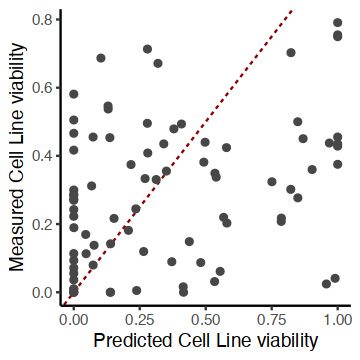

In [261]:
options(repr.plot.width = 3, repr.plot.height = 3)
# We then plot the result :
g <- ggplot(data = drug_sens_m, aes(x=pred, y=true)) +
    geom_abline(intercept =0 , slope = 1, color='darkred', linetype='dashed') +
    geom_point(color='grey28')+ theme_classic() + coord_cartesian() + theme(legend.position="left") + 
    xlab('Predicted Cell Line viability') + ylab('Measured Cell Line viability')
g

## Bottomly approach : PC1 with marker genes 

The idea of Bottomly is to get a proxy for cell-type content by using the first PC to assemble the expression of cell-type signature genes. Then, this "cell-type score" can be correlated with drug sensitivity to obtain an estimation of drug sensitivity: the more positively correlated, the highest the drug sensitivity. 

In [45]:
library(Seurat)
sc.srt <- CreateSeuratObject(counts = exprs(sc.es), project = "vg", min.cells = 3, min.features = 200)
Idents(object = sc.srt) <- sc.es$cellType
sc.srt <- NormalizeData(sc.srt)
sc.srt <- FindVariableFeatures(sc.srt, selection.method = "vst", nfeatures = 2000)
sc.srt <- ScaleData(sc.srt)

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Centering and scaling data matrix



In [46]:
celltype_names = as.character(unique(sc.es$cellType))
markers_l = list() ; markers_top50_l = list()
for(k in 1:length(celltype_names)){
    this_celltype = celltype_names[k]
    message(this_celltype)
    markers_l[[k]] = FindMarkers(sc.srt, ident.1=this_celltype)
    markers_top50_l[[k]] = rownames(head(markers_l[[k]], 50))
}
celltype_markers = unique(do.call(cbind,markers_top50_l))
colnames(celltype_markers) = celltype_names

K562

THP1

SUDHL4

HL60



In [47]:
all_celltypes = colnames(celltype_markers)
pc1_per_celltype = list()
for(k in 1:length(all_celltypes)){
    this_celltype = all_celltypes[k]
    bulk_expr_ct = exprs(bulk.es)[rownames(bulk.es) %in% celltype_markers[,k],]
    bulk_logcpm_ct = log2(1e6*t(t(bulk_expr_ct) / colSums(bulk_expr_ct))+1)
    colsums = colSums(bulk_logcpm_ct)
    prcomp.out = prcomp(t(bulk_logcpm_ct))
    pc1_ct = prcomp.out$x[,1]
    # if it positively correlated, we keep it as it is. Otherwise, we inverse the sign
    if( cor(pc1_ct, colsums) < 0 ){
        pc1_ct = pc1_ct*-1
    }
    pc1_per_celltype[[k]] = pc1_ct
}

In [48]:
pc1_celltypes = data.frame(do.call(cbind,pc1_per_celltype))
colnames(pc1_celltypes) = all_celltypes
pc1_celltypes

,K562,THP1,SUDHL4,HL60
,<dbl>,<dbl>,<dbl>,<dbl>
BULK1,6.04026,-0.06363997,9.208071,4.700603
BULK2,3.52114,1.93454238,1.108894,5.321078
BULK3,10.94556,-1.57327750,-36.668319,4.621042
BULK4,-44.31735,-1.63645752,12.943736,1.648114
BULK5,12.07377,1.07551613,6.805160,-17.348413
BULK6,11.73661,0.26331649,6.602459,1.057576


In [49]:
### Bottomly approach
uniq_conditions = unique(bulk_auc_data$drug)
average_pidk_bottomly = matrix(nrow=length(uniq_conditions), ncol=4)
true_pidk_bottomly = matrix(nrow=length(uniq_conditions), ncol=4)
all_cors_bottomly = list() ; all_rmse_bottomly = list()
for(i in 1:length(uniq_conditions)){
    this_condition = uniq_conditions[i]
    #message(this_condition)
    bulk_auc_data.sub = bulk_auc_data[bulk_auc_data$drug == this_condition,]
    average_pidk_bottomly[i,] = num(cor(pc1_celltypes, bulk_auc_data.sub$auc))
    true_auc_cell_line_sub = true_auc_cell_line[grepl(this_condition, true_auc_cell_line$uniq_id),]
    true_auc_cell_line_sub = true_auc_cell_line_sub[match(all_celltypes, true_auc_cell_line_sub$sample),]
    true_pidk_bottomly[i,] = num(true_auc_cell_line_sub$auc)
    all_cors_bottomly[[i]] = cor(average_pidk_bottomly[i,], true_pidk_bottomly[i,])
    all_rmse_bottomly[[i]] = rmse(average_pidk_bottomly[i,], true_pidk_bottomly[i,])
    #message(cor(average_pidk_bottomly[i,], true_pidk_bottomly[i,]))
}

In [56]:
bottomly_cors = num(all_cors_bottomly)
median(bottomly_cors)

[1] 0.8012892

In [57]:
bottomly_rmse = num(all_rmse_bottomly)
median(bottomly_rmse)

[1] 0.4320435

In [58]:
cor(flatten(average_pidk_bottomly), flatten(true_pidk_bottomly))

[1] 0.4781329

## Compare CLIFF, Karakhelsar and Bottomly approach

In [287]:
df_cors = data.frame(rbind(cbind(cliff_cors_overall, 'CLIFF-overall'), cbind(cliff_cors_highres, 'CLIFF-highres'),
                           cbind(karak_cors, 'Karakhelsar'),cbind(bottomly_cors, 'Bottomly')))
colnames(df_cors) = c('PCC', 'method')
df_cors$method = factor(df_cors$method, levels=c('CLIFF-overall', 'Bottomly', 'CLIFF-highres', 'Karakhelsar'))

pdf 
  2

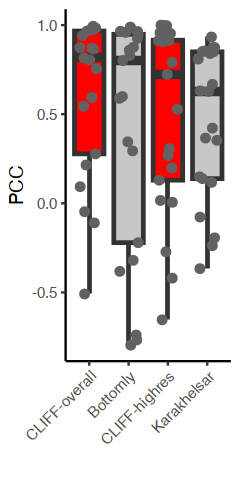

In [291]:
options(repr.plot.width = 2, repr.plot.height = 4)
g <- ggplot(df_cors, aes(x=method, y=num(PCC), fill=method)) + geom_boxplot(size=1, outlier.shape = NA) + 
    geom_jitter(size=2, color='grey38',width=0.25, height=0) +theme_classic() +
    scale_fill_manual(values = ifelse(grepl('CLIFF', levels(df_cors$method)), 'red', 'grey78'))+
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('') + ylab('PCC')
pdf('results/fig5/boxplot_comparison_invitro_PCC.pdf', width=2, height=4) ; g ; dev.off()
g

In [266]:
df_cors = data.frame(rbind(cbind(cliff_rmse_overall, 'CLIFF-overall'), cbind(cliff_rmse_highres, 'CLIFF-highres'),
                           cbind(karak_rmse, 'Karakhelsar'),cbind(bottomly_rmse, 'Bottomly')))
colnames(df_cors) = c('RMSE', 'method')
df_cors$method = factor(df_cors$method, levels=c('CLIFF-overall', 'CLIFF-highres', 'Karakhelsar', 'Bottomly'))

pdf 
  2

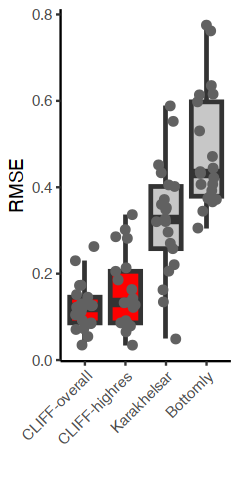

In [267]:
options(repr.plot.width = 2, repr.plot.height = 4)
g <- ggplot(df_cors, aes(x=method, y=num(RMSE), fill=method)) + geom_boxplot(size=1, outlier.shape = NA) + 
    geom_jitter(size=2, color='grey38',width=0.25, height=0) +theme_classic() +
    scale_fill_manual(values = ifelse(grepl('CLIFF', levels(df_cors$method)), 'red', 'grey78'))+
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('') + ylab('RMSE')
pdf('results/fig5/boxplot_comparison_invitro_RMSE.pdf', width=2, height=4) ; g ; dev.off()
g

## Optimize feature selection - how many genes to include ?

In [268]:
run_all_drug_and_timepoints <- function(n.genes, mode='overall'){    
    uniq_conditions = unique(bulk_auc_data$drug)
    average_pidk = matrix(nrow=length(uniq_conditions), ncol=4)
    true_pidk = matrix(nrow=length(uniq_conditions), ncol=4)
    n.selected.genes = list()
    all_cors = list() ; all_rmse = list()
    for(i in 1:length(uniq_conditions)){
        this_condition = uniq_conditions[i]
        message(this_condition)
        bulk_auc_data.sub = bulk_auc_data[bulk_auc_data$drug == this_condition,]

        # Feature Selection 
        bulk_mat = t(exprs(bulk.es))
        drug_data = bulk_auc_data.sub$auc
        sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=n.genes)
        
        # Subset CLIMB output
        climb_res.filt = climb_res
        climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
        climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
        
        # Launch CLIFF
        cliff_highres = cliff(climb_res.filt, bulk_auc_data.sub, min.mutation=0, 
                              max.em.steps = 100, mode=mode, regularization='L2')[[1]]  

        average_pidk[i,] = num(colMeans(cliff_highres))
        true_pidk[i,] = num(true_auc_cell_line[grepl(this_condition, true_auc_cell_line$uniq_id),]$auc)
        all_cors[[i]] = cor(average_pidk[i,], true_pidk[i,])
        all_rmse[[i]] = rmse(average_pidk[i,], true_pidk[i,])
        n.selected.genes[[i]] = length(sel.genes)
        message(cor(average_pidk[i,], true_pidk[i,]))   
    }
    overall_pcc = cor(flatten(average_pidk), flatten(true_pidk))
    return(list(all_cors, all_rmse, n.selected.genes))
}

In [269]:
min.n.genes_vec = c(1,10,25,50,100,200,500,1000,2000)
pcc_overall = list() ; rmse_overall = list() ; n_genes_overall = list()
pcc_highres = list() ; rmse_highres = list() ; n_genes_highres = list()
for(i in 1:length(min.n.genes_vec)){
    n.genes = min.n.genes_vec[i]
    message(paste0('n_genes: ', n.genes))
    # CLIFF-overall
    results_ = suppressMessages(run_all_drug_and_timepoints(n.genes, mode='overall'))
    pcc_overall[[i]] = num(results_[[1]])
    rmse_overall[[i]] = num(results_[[2]])
    n_genes_overall[[i]] = num(results_[[3]])
    # CLIFF-highres
    results_ = suppressMessages(run_all_drug_and_timepoints(n.genes, mode='highres'))
    pcc_highres[[i]] = num(results_[[1]])
    rmse_highres[[i]] = num(results_[[2]])
    n_genes_highres[[i]] = num(results_[[3]])
}

n_genes: 1

n_genes: 10

n_genes: 25

n_genes: 50

n_genes: 100

n_genes: 200

n_genes: 500

n_genes: 1000

n_genes: 2000



In [270]:
pcc_overall_m = data.frame(do.call(rbind, pcc_overall))
rownames(pcc_overall_m) = min.n.genes_vec ; colnames(pcc_overall_m) = uniq_conditions
pcc_overall_m$n_genes = rownames(pcc_overall_m)
pcc_overall_melt = melt(pcc_overall_m)
colnames(pcc_overall_melt) = c('N genes', 'condition', 'PCC')
order_ = order(unique(num(pcc_overall_melt$`N genes`)))
pcc_overall_melt$`N genes` = paste0('>', pcc_overall_melt$`N genes`)
pcc_overall_melt$`N genes` = gsub('>1000', '>1k', gsub('>2000', '>2k', pcc_overall_melt$`N genes`))
pcc_overall_melt$`N genes` = factor(pcc_overall_melt$`N genes`, levels=unique(pcc_overall_melt$`N genes`[order_]))

g1 <- ggplot(pcc_overall_melt, aes(x=`N genes`, y=num(PCC))) + geom_boxplot() + ylab('PCC')

rmse_overall_m = data.frame(do.call(rbind, rmse_overall))
rownames(rmse_overall_m) = min.n.genes_vec ; colnames(rmse_overall_m) = uniq_conditions
rmse_overall_m$n_genes = rownames(rmse_overall_m)
rmse_overall_melt = melt(rmse_overall_m)
colnames(rmse_overall_melt) = c('N genes', 'condition', 'rmse')
order_ = order(unique(num(rmse_overall_melt$`N genes`)))
rmse_overall_melt$`N genes` = paste0('>', rmse_overall_melt$`N genes`)
rmse_overall_melt$`N genes` = gsub('>1000', '>1k', gsub('>2000', '>2k', rmse_overall_melt$`N genes`))
rmse_overall_melt$`N genes` = factor(rmse_overall_melt$`N genes`, levels=unique(rmse_overall_melt$`N genes`[order_]))

g2 <- ggplot(rmse_overall_melt, aes(x=`N genes`, y=num(rmse))) + geom_boxplot() + ylab('RMSE')

n_genes_overall_m = data.frame(do.call(rbind, n_genes_overall))
rownames(n_genes_overall_m) = min.n.genes_vec ; colnames(n_genes_overall_m) = uniq_conditions
n_genes_overall_m$n_genes = rownames(n_genes_overall_m)
n_genes_overall_melt = melt(n_genes_overall_m)
colnames(n_genes_overall_melt) = c('N genes', 'condition', 'n_genes')
order_ = order(unique(num(n_genes_overall_melt$`N genes`)))
n_genes_overall_melt$`N genes` = paste0('>', n_genes_overall_melt$`N genes`)
n_genes_overall_melt$`N genes` = gsub('>1000', '>1k', gsub('>2000', '>2k', n_genes_overall_melt$`N genes`))
n_genes_overall_melt$`N genes` = factor(n_genes_overall_melt$`N genes`, levels=unique(n_genes_overall_melt$`N genes`[order_]))

library(scales) # to access break formatting functions
g3 <- ggplot(n_genes_overall_melt, aes(x=`N genes`, y=num(n_genes))) + geom_boxplot() + 
    ylab('N selected genes') + xlab('N genes') + 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),labels = trans_format("log10", math_format(10^.x)))

Using n_genes as id variables

Using n_genes as id variables

Using n_genes as id variables



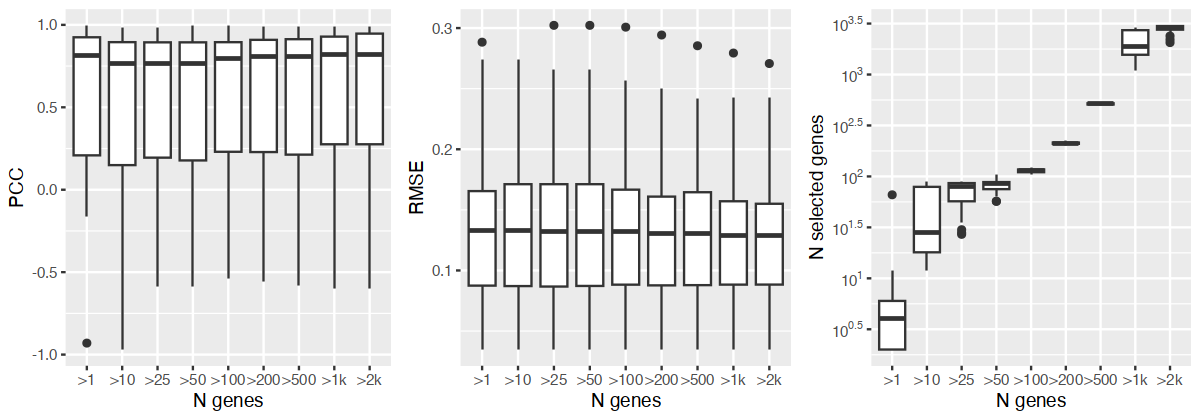

In [271]:
library(ggpubr)
options(repr.plot.width = 10, repr.plot.height = 3.5)
g <- ggarrange(g1,g2,g3, ncol=3, nrow=1)
#pdf('results/fig5/gene_selection_optimization_overall.pdf', width=10, height=3.5) ; g ; dev.off()
g

In [272]:
pcc_highres_m = data.frame(do.call(rbind, pcc_highres))
rownames(pcc_highres_m) = min.n.genes_vec ; colnames(pcc_highres_m) = uniq_conditions
pcc_highres_m$n_genes = rownames(pcc_highres_m)
pcc_highres_melt = melt(pcc_highres_m)
colnames(pcc_highres_melt) = c('N genes', 'condition', 'PCC')
order_ = order(unique(num(pcc_highres_melt$`N genes`)))
pcc_highres_melt$`N genes` = paste0('>', pcc_highres_melt$`N genes`)
pcc_highres_melt$`N genes` = gsub('>1000', '>1k', gsub('>2000', '>2k', pcc_highres_melt$`N genes`))
pcc_highres_melt$`N genes` = factor(pcc_highres_melt$`N genes`, levels=unique(pcc_highres_melt$`N genes`[order_]))

g1 <- ggplot(pcc_highres_melt, aes(x=`N genes`, y=num(PCC))) + geom_boxplot() + ylab('PCC')

rmse_highres_m = data.frame(do.call(rbind, rmse_highres))
rownames(rmse_highres_m) = min.n.genes_vec ; colnames(rmse_highres_m) = uniq_conditions
rmse_highres_m$n_genes = rownames(rmse_highres_m)
rmse_highres_melt = melt(rmse_highres_m)
colnames(rmse_highres_melt) = c('N genes', 'condition', 'rmse')
order_ = order(unique(num(rmse_highres_melt$`N genes`)))
rmse_highres_melt$`N genes` = paste0('>', rmse_highres_melt$`N genes`)
rmse_highres_melt$`N genes` = gsub('>1000', '>1k', gsub('>2000', '>2k', rmse_highres_melt$`N genes`))
rmse_highres_melt$`N genes` = factor(rmse_highres_melt$`N genes`, levels=unique(rmse_highres_melt$`N genes`[order_]))

g2 <- ggplot(rmse_highres_melt, aes(x=`N genes`, y=num(rmse))) + geom_boxplot() + ylab('RMSE')

n_genes_highres_m = data.frame(do.call(rbind, n_genes_highres))
rownames(n_genes_highres_m) = min.n.genes_vec ; colnames(n_genes_highres_m) = uniq_conditions
n_genes_highres_m$n_genes = rownames(n_genes_highres_m)
n_genes_highres_melt = melt(n_genes_highres_m)
colnames(n_genes_highres_melt) = c('N genes', 'condition', 'n_genes')
order_ = order(unique(num(n_genes_highres_melt$`N genes`)))
n_genes_highres_melt$`N genes` = paste0('>', n_genes_highres_melt$`N genes`)
n_genes_highres_melt$`N genes` = gsub('>1000', '>1k', gsub('>2000', '>2k', n_genes_highres_melt$`N genes`))
n_genes_highres_melt$`N genes` = factor(n_genes_highres_melt$`N genes`, levels=unique(n_genes_highres_melt$`N genes`[order_]))

library(scales) # to access break formatting functions
g3 <- ggplot(n_genes_highres_melt, aes(x=`N genes`, y=num(n_genes))) + geom_boxplot() + 
    ylab('N selected genes') + xlab('N genes') + 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),labels = trans_format("log10", math_format(10^.x)))

Using n_genes as id variables

Using n_genes as id variables

Using n_genes as id variables



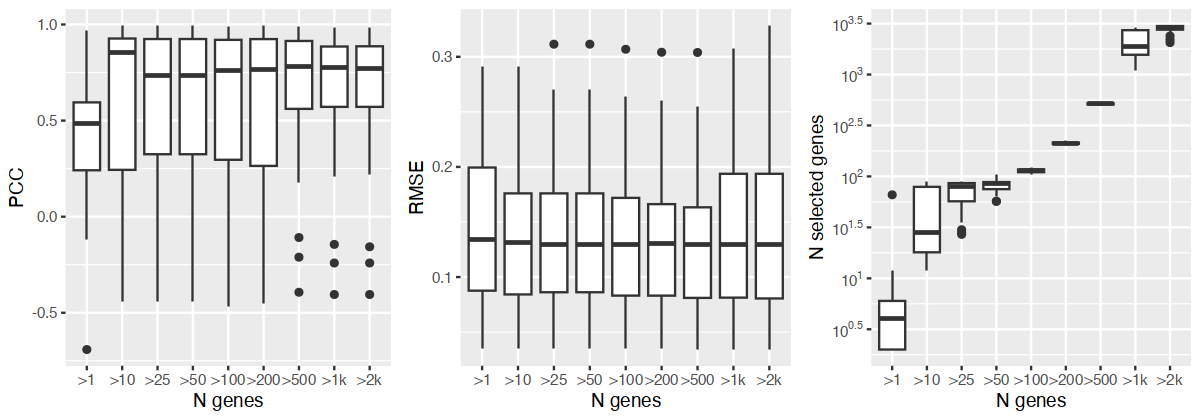

In [273]:
library(ggpubr)
options(repr.plot.width = 10, repr.plot.height = 3.5)
g <- ggarrange(g1,g2,g3, ncol=3, nrow=1)
#pdf('results/fig5/gene_selection_optimization_highres.pdf', width=10, height=3.5) ; g ; dev.off()
g